## Impute cruise time data using neighboring historical cruise time

* Do not process data here. Only focus on the heat maps below
* Process data in the compute_ notebook of the same name

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [2]:
# trip_df_15m = pd.read_csv('../data/trip_df_15m.csv')
cruise_time_15m = pd.read_csv('../data/cruise_time_15m.csv')
cruise_time_15m = cruise_time_15m.astype({'dropoff_datetime_index': 'int32'})
adjacent_zone = pd.read_csv('../data/adjacent_zone.csv')

In [3]:
def impute_from_adjacent_zones(cruise_time_df, adjacent_zone, cruise_time_col, time_interval):
    
    ## pivot
    cruise_df_imputed = cruise_time_df.pivot_table(index='dropoff_datetime_index', 
                                   columns='taxizone_id', 
                                   values=cruise_time_col).copy()
    
    ## original cruise df to check for nan. Only imputed values are added
    cruise_df_template = cruise_df_imputed.copy()

    ## at each time interval, loop through each of the zone and find its adjacent
    ## if its cruise time is NaN
    taxi_zone_list = list(cruise_df_imputed.columns)
    timestamp_list = list(cruise_df_imputed.index)
    for t in timestamp_list:
        for z in taxi_zone_list:
            adjacent_list = np.array(adjacent_zone.loc[adjacent_zone['zone1'] == z]['zone2'])
            try:
                if np.isnan(cruise_df_template.loc[t, z]):
                    cruise_df_imputed.loc[t, z] = np.mean(cruise_df_template.loc[t, adjacent_list])
            except:
                pass
    ## unpivot
    cruise_df_imputed = cruise_df_imputed.stack().reset_index(name=cruise_time_col)
    
    ## compute interval from the imputed cruise time
    cruise_df_imputed[cruise_time_col + '_INT'] = [t//time_interval for t in cruise_df_imputed[cruise_time_col]]
    return cruise_df_imputed

In [4]:
cruise_df_imputed = impute_from_adjacent_zones(cruise_time_15m, adjacent_zone, 'med_cruise_time', 15)

//anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:961: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  return getattr(section, self.name)[new_key]


## Pre vs Post imputation with 15 minute interval - by minutes

Text(767.7272727272725, 0.5, 'timestamp')

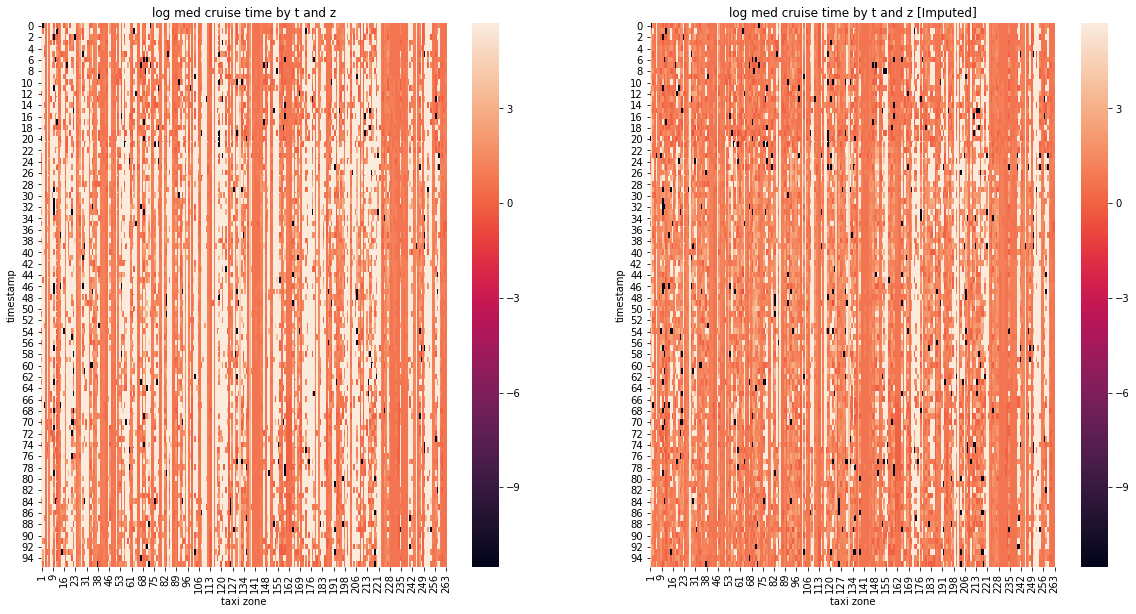

In [5]:
cruise_df = cruise_time_15m.copy()
cruise_df['med_cruise_time'] = np.log(cruise_df['med_cruise_time'] + 1e-5)
cruise_df = cruise_df.pivot_table(index='dropoff_datetime_index', 
                                  columns='taxizone_id', 
                                  values='med_cruise_time')
cruise_df.fillna(np.log(300), inplace=True)

cruise_df_imputed_heatmap = cruise_df_imputed.copy()
cruise_df_imputed_heatmap['med_cruise_time'] = np.log(cruise_df_imputed_heatmap['med_cruise_time'] + 1e-5)
cruise_df_imputed_heatmap = cruise_df_imputed_heatmap\
                        .pivot_table(index='dropoff_datetime_index', 
                                     columns='taxizone_id', 
                                     values='med_cruise_time')
cruise_df_imputed_heatmap.fillna(np.log(300), inplace=True)


fig, ax = plt.subplots(1,2, figsize=(20, 10))
sns.heatmap(cruise_df, ax=ax[0])
ax[0].set_title('log med cruise time by t and z')
ax[0].set_xlabel('taxi zone')
ax[0].set_ylabel('timestamp')

sns.heatmap(cruise_df_imputed_heatmap, ax=ax[1])
ax[1].set_title('log med cruise time by t and z [Imputed]')
ax[1].set_xlabel('taxi zone')
ax[1].set_ylabel('timestamp')
# fig.savefig('../heatmap_cruise_time.png')

## Pre vs Post imputation with 15 minute interval - by interval

Text(767.7272727272725, 0.5, 'timestamp')

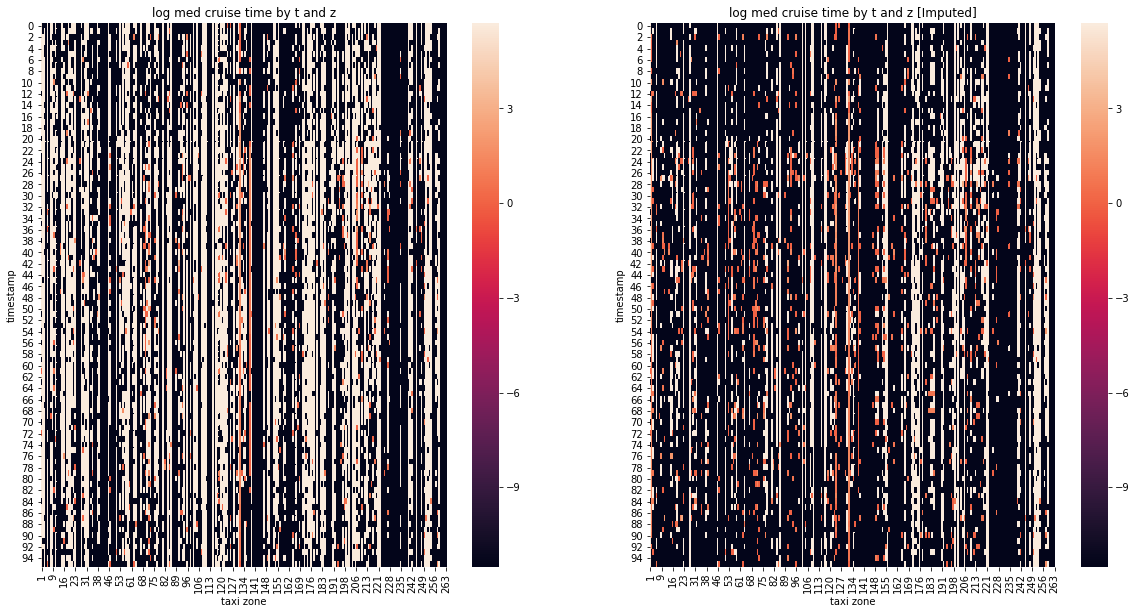

In [6]:
cruise_df = cruise_time_15m.copy()
cruise_df['med_cruise_time_INT'] = np.log(cruise_df['med_cruise_time_INT'] + 1e-5)
cruise_df = cruise_df.pivot_table(index='dropoff_datetime_index', 
                                  columns='taxizone_id', 
                                  values='med_cruise_time_INT')
cruise_df.fillna(np.log(300), inplace=True)

cruise_df_imputed_heatmap = cruise_df_imputed.copy()
cruise_df_imputed_heatmap['med_cruise_time_INT'] = np.log(cruise_df_imputed_heatmap['med_cruise_time_INT'] + 1e-5)
cruise_df_imputed_heatmap = cruise_df_imputed_heatmap\
                        .pivot_table(index='dropoff_datetime_index', 
                                     columns='taxizone_id', 
                                     values='med_cruise_time_INT')
cruise_df_imputed_heatmap.fillna(np.log(300), inplace=True)


fig, ax = plt.subplots(1,2, figsize=(20, 10))
sns.heatmap(cruise_df, ax=ax[0])
ax[0].set_title('log med cruise time by t and z')
ax[0].set_xlabel('taxi zone')
ax[0].set_ylabel('timestamp')

sns.heatmap(cruise_df_imputed_heatmap, ax=ax[1])
ax[1].set_title('log med cruise time by t and z [Imputed]')
ax[1].set_xlabel('taxi zone')
ax[1].set_ylabel('timestamp')
# fig.savefig('../heatmap_cruise_time.png')